In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import collections
from asl_data import AslDb, SinglesData
from asl_utils import show_errors
from asl_test import train_all_words
from my_recognizer import recognize
from my_model_selectors import *
import warnings, copy
    
asl = AslDb() # initializes the database
type(asl),asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

(asl_data.AslDb,
              left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
 video frame                                                           
 98    0         149     181      170      175     161      62  woman-1
       1         149     181      170      175     161      62  woman-1
       2         149     181      170      175     161      62  woman-1
       3         149     181      170      175     161      62  woman-1
       4         149     181      170      175     161      62  woman-1)

In [2]:
%reload_ext autoreload
%autoreload 2
import math
from asl_data import AslDb

def zscalewith(x, y='speaker')->pd.DataFrame:
    #zscale
    df_mean = asl.df.groupby('speaker').mean()
    df_std = asl.df.groupby('speaker').std()
    return (asl.df[x] - asl.df[y].map(df_mean[x])) / asl.df[y].map(df_std[x])
def standardize(item, group='speaker')->pd.DataFrame:
    # Using MinMaxScaler: X_norm = (x-xmin)/(xmax-xmin)'
    df_min = asl.df.groupby('speaker').min()
    df_max = asl.df.groupby('speaker').max()
    x, y = item, group
    mmscaled = (asl.df[x] - asl.df[y].map(df_min[x]))
    mmscaled /= (asl.df[y].map(df_max[x]) - asl.df[y].map(df_min[x]))
    return mmscaled
def stdize(item, group='speaker')->pd.DataFrame:
    # Using alt Scaler: X_norm = (x-xmean)/(xmax-xmin)'
    df_min = asl.df.groupby('speaker').min()
    df_max = asl.df.groupby('speaker').max()
    df_mean = asl.df.groupby('speaker').mean()  
    x, y = item, group
    mmscaled = (asl.df[x] - asl.df[y].map(df_mean[x]))
    mmscaled /= (asl.df[y].map(df_max[x]) - asl.df[y].map(df_min[x]))
    return mmscaled
# calculations - Polar Positions
def radius(x, y)->pd.DataFrame:
    return (np.sqrt(np.power(asl.df[x], 2) + np.power(asl.df[y], 2)))
def angle(x, y)->pd.DataFrame:
    return (np.arctan2(asl.df[x], asl.df[y]))
def distance(x, y)->pd.DataFrame: 
    return asl.df[x] - asl.df[y]

# ground features
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
features_ground = ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']

# features - normalised x,y 
asl.df['norm-lx'] = zscalewith('left-x')
asl.df['norm-rx'] = zscalewith('right-x')
asl.df['norm-ly'] = zscalewith('left-y')
asl.df['norm-ry'] = zscalewith('right-y')
features_norm = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

# features - polars
asl.df['polar-rr'] = radius('grnd-rx', 'grnd-ry')
asl.df['polar-lr'] = radius('grnd-lx', 'grnd-ly')
asl.df['polar-rtheta'] = angle('grnd-rx', 'grnd-ry')
asl.df['polar-ltheta'] = angle('grnd-lx', 'grnd-ly')
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

# features - x,y deltas (velocity proxy)
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(value=0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(value=0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(value=0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(value=0)
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

# normalised grounds r,l*x,y:
asl.df['ngrnd-rx'] = standardize('grnd-rx')
asl.df['ngrnd-ry'] = standardize('grnd-ry')
asl.df['ngrnd-lx'] = standardize('grnd-lx')
asl.df['ngrnd-ly'] = standardize('grnd-ly')
features_norm_ground = ['ngrnd-rx', 'ngrnd-ry', 'ngrnd-lx', 'ngrnd-ly']

# normalised distances:

asl.df['dist-rlx'] = distance('right-x', 'left-x')
asl.df['dist-rly'] = distance('right-y', 'left-y')
asl.df['dist-rlr'] = distance('polar-rr', 'polar-lr')
asl.df['dist-theta'] = distance('polar-rtheta', 'polar-ltheta')
features_dist = ['dist-xrl', 'dist-yrl', 'dist-rlrad', 'dist-theta']
asl.df['ndist-xrl'] = standardize('dist-rlx')
asl.df['ndist-yrl'] = standardize('dist-rly')
asl.df['ndist-rlrad'] = standardize('dist-rlr')
asl.df['ndist-theta'] = standardize('dist-theta')
features_ndist = ['ndist-xrl', 'ndist-yrl', 'ndist-rlrad', 'ndist-theta']

# normalised polars:
asl.df['npolar-rrad'] = standardize('polar-rr')
asl.df['npolar-lrad'] = standardize('polar-lr')
asl.df['npolar_ltheta'] = standardize('polar-rtheta')
asl.df['npolar_rtheta'] = standardize('polar-ltheta')
features_npolar = ['npolar-rrad', 'npolar_rtheta',
                   'npolar-lrad', 'npolar_ltheta']

# normalised deltas (Normalised Velocity Proxy):
asl.df['ndelta-rx'] = standardize('delta-rx')
asl.df['ndelta-ry'] = standardize('delta-ry')
asl.df['ndelta-lx'] = standardize('delta-lx')
asl.df['ndelta-ly'] = standardize('delta-ly')
features_ndelta = ['ndelta-rx', 'ndelta-ry', 'ndelta-lx', 'ndelta-ly']

# normalised polar deltas (Normalised Radial Deltas):
asl.df['dpolar-rr'] = asl.df['polar-rr'].diff().fillna(value=0)
asl.df['dpolar-lr'] = asl.df['polar-lr'].diff().fillna(value=0)
asl.df['dpolar-rtheta'] = asl.df['polar-rtheta'].diff().fillna(value=0)
asl.df['dpolar-ltheta'] = asl.df['polar-ltheta'].diff().fillna(value=0)
features_ddpolar = ['ddelpolar-rr', 'ddelpolar-lr',
                    'ddelpolar_ltheta', 'ddelpolar_rtheta']

asl.df['ndelpolar-rr'] = standardize('dpolar-rr')
asl.df['ndelpolar-lr'] = standardize('dpolar-lr')
asl.df['ndelpolar_ltheta'] = standardize('dpolar-rtheta')
asl.df['ndelpolar_rtheta'] = standardize('dpolar-ltheta')
features_ndpolar = ['ndelpolar-rr', 'ndelpolar-lr',
                    'ndelpolar_ltheta', 'ndelpolar_rtheta']

# normalised delta-deltas: acceleration proxy
asl.df['d2el-rx'] = asl.df['delta-rx'].diff().fillna(value=0)
asl.df['d2el-ry'] = asl.df['delta-ry'].diff().fillna(value=0)
asl.df['d2el-lx'] = asl.df['delta-lx'].diff().fillna(value=0)
asl.df['d2el-ly'] = asl.df['delta-ly'].diff().fillna(value=0)
features_ddelta = ['d2el-rx', 'd2el-ry', 'd2el-lx', 'd2el-ly', ]
asl.df['nd2el-rx'] = stdize('d2el-rx')
asl.df['nd2el-ry'] = stdize('d2el-ry')
asl.df['nd2el-lx'] = stdize('d2el-lx')
asl.df['nd2el-ly'] = stdize('d2el-ly')
features_nddelta = ['nd2el-rx', 'nd2el-ry', 'nd2el-lx', 'nd2el-ly', ]

# define a list named 'features_custom' for building the training set
features_custom = features_npolar + features_ndelta + features_ndist

features_custom_2 = features_npolar + features_ndelta + features_ndist + features_ndpolar

features_custom_3 = features_npolar + features_ndelta +  features_ndist + features_ndpolar + features_nddelta

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

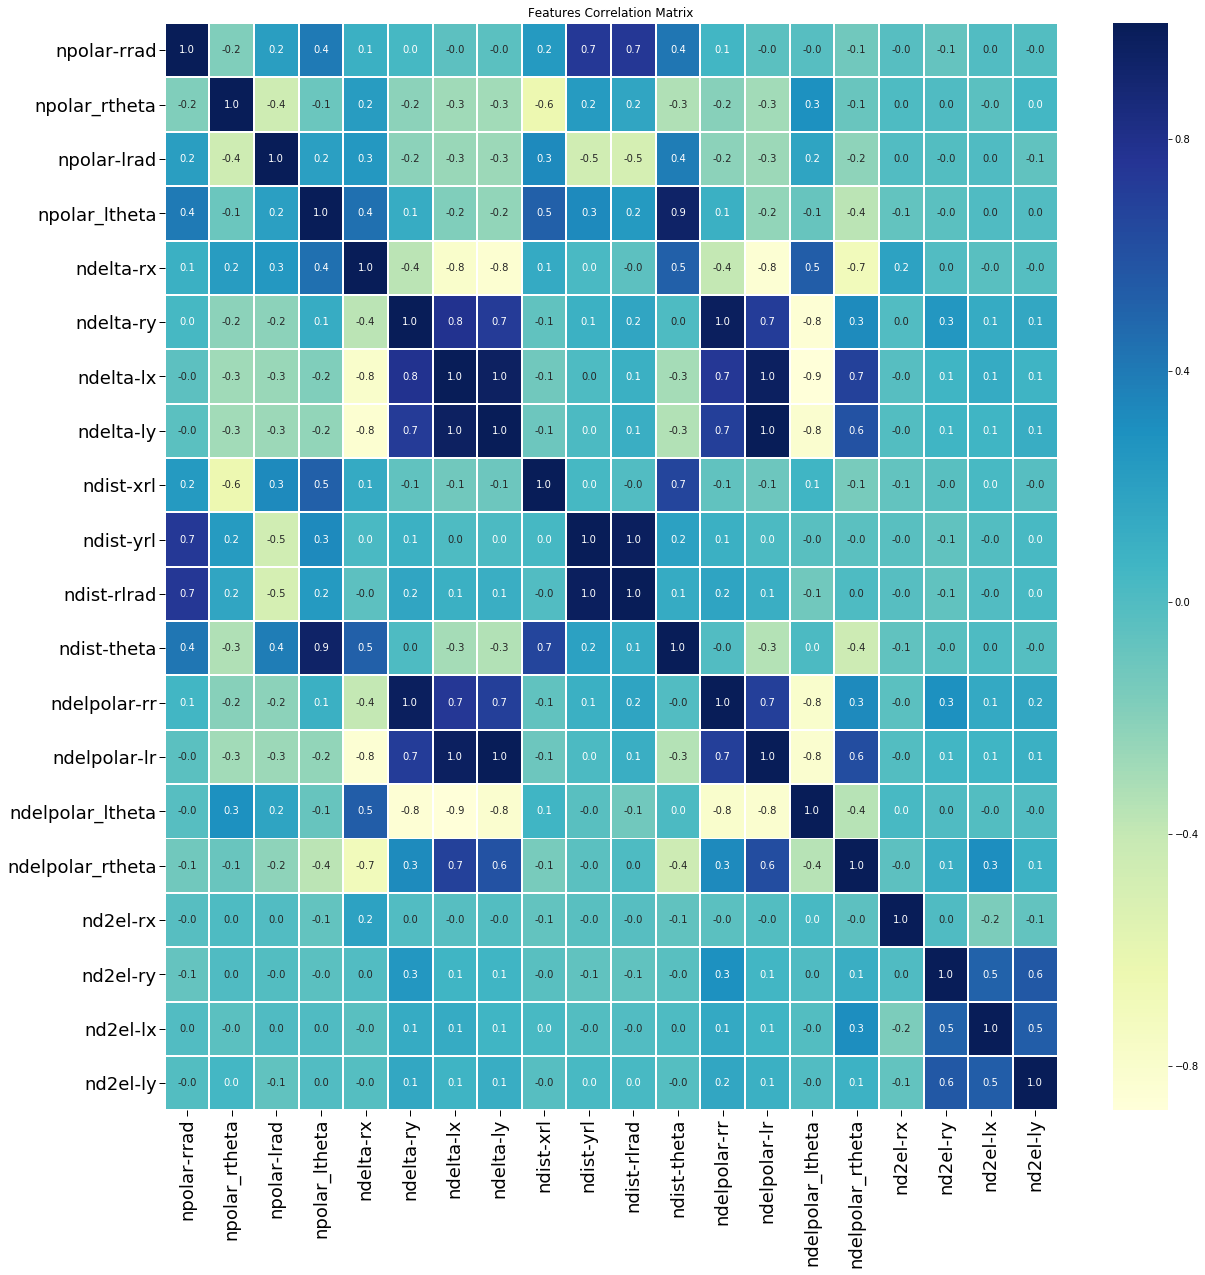

In [8]:
import seaborn as sns
plt.figure(figsize= (20,20))
plt.title("Features Correlation Matrix")
plt.tick_params(axis='both', direction='out', length=6, width=1, colors='black', pad=2, labelsize=18)
sns.heatmap(asl.df[features_custom_3].corr(), annot=True, fmt=".1f", linewidths=1.0, cmap="YlGnBu")

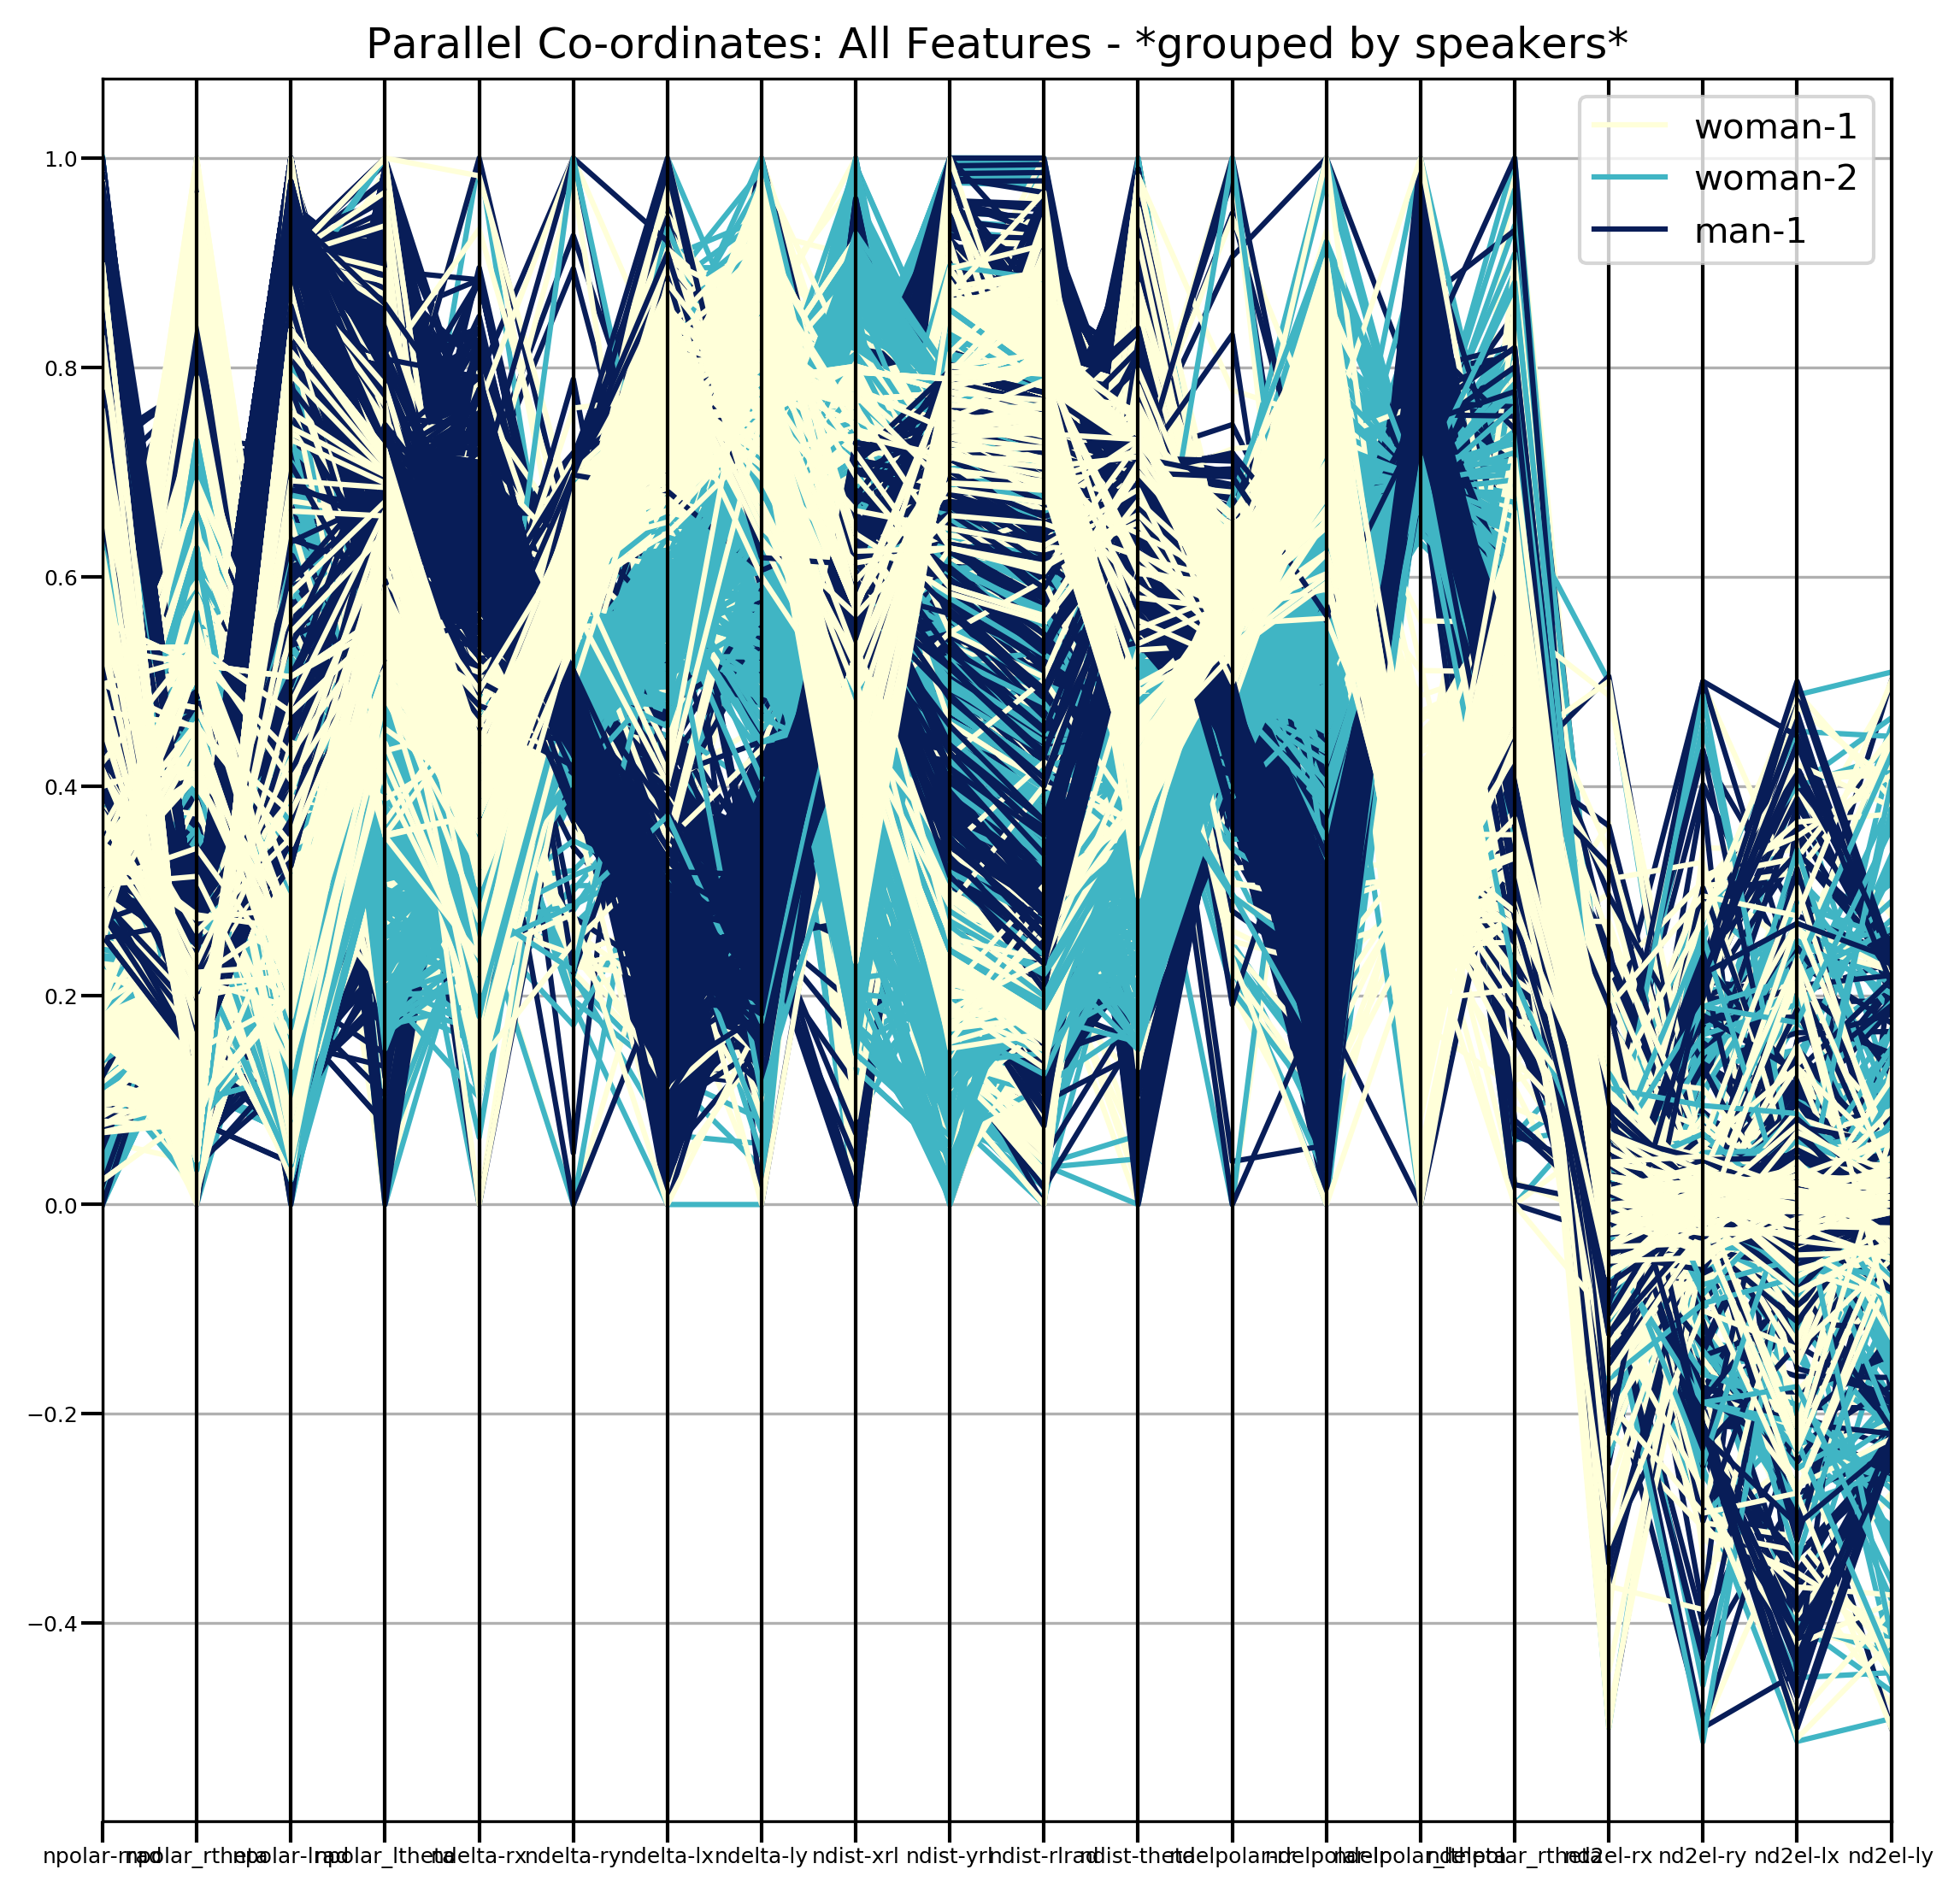

In [10]:
from pandas import plotting as pdplt
plt.figure(figsize=(9,9), dpi=300)
plt.title('Parallel Co-ordinates: All Features - *grouped by speakers*')
plt.tick_params(axis='both', direction='out', length=6, width=1, colors='black', pad=1, labelsize=6)
pdplt.parallel_coordinates(asl.df[features_custom_3 + ['speaker']], 'speaker', colormap='YlGnBu')

In [10]:
def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
        
def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()


In [13]:
from my_model_selectors import *
from my_recognizer import *
from asl_data import *
import arpa

In [14]:
%reload_ext autoreload
%autoreload 2
features = features_custom_2
model_selector = SelectorBIC

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

TypeError: 'NoneType' object is not subscriptable

In [8]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()
df_probs['JOHN'].iloc[0]

284.69109918240179

In [ ]:
from lm import LM as arpalm
slm = arpalm('.\data\lm_ukn.3.lm')

In [ ]:
slm.tg_prob(slm.start,slm.get_word_id("JOHN"),slm.end)

In [ ]:
%reload_ext autoreload
%autoreload 2
from  search import ngramguess

models = arpa.loadf('.\data\lm_ukn.3.lm')
lm = models[0]

guesses={}
second_best_list = []
for t in test_set.sentences_index:
    words = test_set.sentences_index[t]    # way to identify where each sentence starts and stops
    my_sentence={}
    # set up a list of dictionaries, for each word in the unknown phrase
    for i in range(words[0], words[-1]+1):
        my_sentence[i] = df_probs.loc[i].to_dict()
        
    # find the best sentence option for those words
    sentence = ngramguess(lm, my_sentence, num_words_to_test=3).score()
    
    # split into individual words and add these to the ongoing dictionary for best guesses
    guess = sentence.split(' ')
    j = len(guesses)
    for g in range(len(guess)-1):
        guesses[j+g] = guess[g]
        
show_errors(guesses, test_set)

In [ ]:
%reload_ext autoreload
%autoreload 2
from  search import ngramguess

models = arpa.loadf('.\data\lm_ukn.3.lm')
lm = models[0]

guesses={}
second_best_list = []
for t in test_set.sentences_index:
    words = test_set.sentences_index[t]    # way to identify where each sentence starts and stops
    my_sentence={}
    # set up a list of dictionaries, for each word in the unknown phrase
    for i in range(words[0], words[-1]+1):
        my_sentence[i] = df_probs.loc[i].to_dict()
        
    # find the best sentence option for those words
    sentence = ngramguess(lm, my_sentence, num_words_to_test=3).score_i()
    
    # split into individual words and add these to the ongoing dictionary for best guesses
    guess = sentence.split(' ')
    j = len(guesses)
    for g in range(len(guess)-1):
        guesses[j+g] = guess[g]
        
show_errors(guesses, test_set)